# Lecture 11. Introduction to WRDS and FF Factors

* Introduce Fama-French size and value factors (Q3 in PS3)   <br>
<br>
* Introduce the datasets in WRDS that are possibly useful in your future dissertation  <br>
<br>

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from scipy import stats
pd.options.display.max_rows = 12
import statsmodels.api as sm
import statsmodels.formula.api as smf

* If you want to execute the SQL command in ```wrds``` database, please execute ```pip install wrds``` in terminal (Mac OS).
  
* However, as far as I know, the student account does not support such operation. Hence, download the datasets using the below Dropbox link.

In [ ]:
import wrds

#### Please download the datasets using the following Dropbox link:

https://www.dropbox.com/scl/fi/41210ib08bdx4yo3ej6xa/lecture11.zip?rlkey=63mecwa5zij9uajfi2e5n2rbw&st=xsqx9n01&dl=0

---

## 11.1 Fama-French Size and Value Factors

#### Reference

Fama, Eugene F., and Kenneth R. French, 1993, Common risk factors in the returns on stocks and bonds, Journal of Financial Economics 33, 3–56.


- Previous lecture: CAPM fails to explain the average returns of many test assets
   * In OLS regressions, the pricing errors $\alpha$ are significantly different from zeros. 
   * The market factor seems insufficient to capture all the priced sources of risks. 
   * Time-varying market beta doesn't seem to explain the failure of CAPM. <br>
<br>
- What are the missing drivers of stock returns? Can we improve the CAPM? <br>
<br>
- Book-to-market (BE/ME) ratio
   * In accounting, book value is the value of an asset according to its balance sheet statement. 
   * Historically, firms that have high BE/ME tend to have low earnings on assets.
   * The low earnings persist for at least five years before and five years after book-to-market equity is measured. 
   * High BE/ME ratio seems to imply that a firm is risky due to the persistent low earnings.
   * High risk means high return: stocks with higher BE/ME ratio should earn higher average returns than others.   <br>
<br>
- Firm size
   * Controlling for book-to-market equity, small firms tend to have lower earnings on assets than big firms.
   * Small firms can suffer along earnings depression that bypasses big firms (e.g., 1980-1982 recession).
   * It seems that small firms are riskier than large firms; hence, they should earn higher average returns. 

### Null Hypothesis:

1. High BE/ME stocks, on average, earn higher returns than low BE/ME ones. <br>
2. Small stocks, on average, earn higher returns than large ones. 

### Splitting the stocks into six groups

* Three BE-ME groups: L (low), M (middle), and H (high)
* Two ME groups: S (small) and B (big)
* Six portfolios: S/L, S/M, S/H, B/L, B/M, B/H

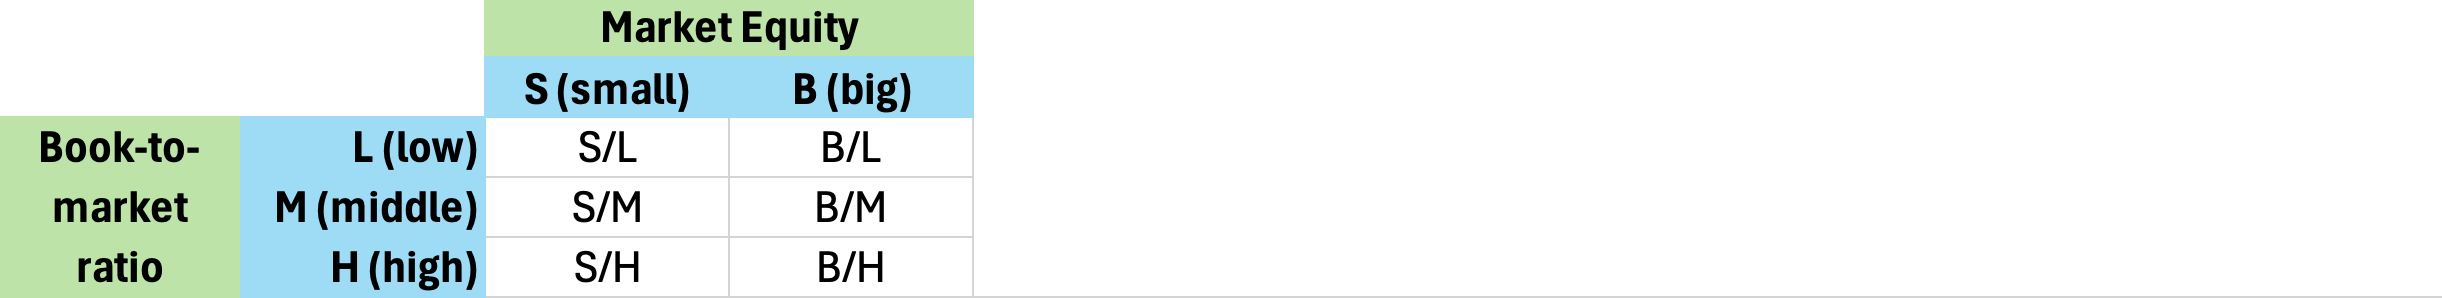

### Definition of HML

* The portfolio HML (high minus low), meant to mimic the risk factor in returns related to book-to-market equity. <br>
<br>
* HML is the difference, each month, between the simple average of the returns on the two high-BE/ME portfolios (S/H and B/H) and the average of the returns on the two low-BE/ME portfolios (S/L and B/L). 
   * $HML = \frac{1}{2} \times (S/H + B/H) - \frac{1}{2} \times (S/L + B/L)$
   * In HML, we invest 0.5 in S/H and B/H portfolios, and short sell 0.5 in S/L and B/L portfolios (zero-cost strategy)   
   * Therefore, HML is an excess return  
   * Similarly, in the market excess return (MKT-RF), we invest 1 unit in MKT portfolio, and short sell the risk-free bond (RF)  <br>
<br>
* The two components of HML are returns on high- and low- BE/ME portfolios with about the same weighted-average size. Thus the difference between the two returns should be largely free of the size effect, focusing instead on the different return behaviors of high- and low-BE/ME firms. 

### Definition of SMB

* Size - the portfolio **SMB (small minus big)**, meant to mimic the risk factor in returns related to size. <br>
<br>
* It is the difference, each month, between the simple average of the returns on the three small-stock portfolios (S/L, S/M, and S/H) and the simple average of the returns on the three big-stock portfolios (B/L, B/M, and B/H). 
   * $SMB = \frac{1}{3} \times (S/L + S/M + S/H) - \frac{1}{3} \times (B/L + B/M + B/H)$  <br>
<br>
* Thus, SMB is the difference between the returns on small- and big-stock portfolios with about the same weighted-average book-to-market equity. This difference should be largely free of the influence of BE/ME, focusing instead on the different return behaviors of small and big stocks.  <br>
<br>
* Both SMB and HML are excess returns.
   * In your problem set, for simplicity, just add risk-free rate to SMB and HML to get gross returns of these two strategies

### Dimensional Fund Advisors (DFA)

- DFA was founded by David Booth and other two partners in Chicago in 1981. 
- The founders studied at U Chicago under Eugene Fama and Ken French, and learned the firm size and book-to-market ratio can predict stock returns in the 1980s. 
- They later introduced their index fund products that tilt the portfolios towards smaller company stocks and value stocks, hence operating differently from most index funds at the time. 
- Their products were extremely popular in the 1990s due to the strong performance of smaller and value stocks. 
- AUM of DFA in 2023: $677 billion.

### Downloading SMB and HML from WRDS

Install the ```wrds``` package following: https://pypi.org/project/wrds/.

- In this lecture note, I will show you how to download data from the DBMS using SQL. 

In [ ]:
###################
# Connect to WRDS #
###################

conn = wrds.Connection()

In [ ]:
_ff = conn.get_table(library='ff', table='factors_monthly')

#_ff = pd.read_parquet('data/lecture11/FF3_monthly.parquet')

_ff.head()

In [ ]:
_ff.dtypes

In [ ]:
_ff = _ff[['date','mktrf','smb','hml','rf']]

_ff['mktrf'] = pd.to_numeric(_ff['mktrf'])
_ff['smb'] = pd.to_numeric(_ff['smb'])
_ff['hml'] = pd.to_numeric(_ff['hml'])
_ff['rf'] = pd.to_numeric(_ff['rf'])

_ff['date'] = pd.to_datetime(_ff['date']).copy()
_ff['date'] = _ff['date'] + MonthEnd(0)

_ff = _ff.set_index('date')
_ff

#### Select the subsample starting from July 1963

Before this date, we had much less listed companies in the database

In [ ]:
_ff = _ff.loc['1963-07':]

In [ ]:
print('Annualised Sharpe ratios of SMB and HML:')
print(np.sqrt(12) * _ff[['smb','hml']].mean() / _ff[['smb','hml']].std())

### Cumulative performance of HML and SMB

* Transform the data such that they have the same in-sample volatility (roughly the same amount of investment risk) 
* Compute cumulative returns of HML and SMB

In [ ]:
ff_factors_plot = _ff[['smb', 'hml']]

### Normalize the monthly standard deviation to be 1%
ff_factors_plot = 0.01 * ff_factors_plot / ff_factors_plot.std()
ff_factors_plot.std()

In [ ]:
plt.rc('figure', figsize=(10, 5))
(ff_factors_plot+1).cumprod().plot()

### Can SMB and HML explain the cross-section of 25 size- and value-sorted portfolios studied in lecture 10?

In lecture 10, we show that the CAPM fails to explain the cross-sectional spreads of average returns. 

* In the conditional/unconditional model, a higher market beta often implies a lower expected returns $\implies$ failure of CAPM.


#### Fama-French three-factor model:
$$
\mathbf{E} [ R_i ] - R_f = \beta^{mkt}_i \big( \mathbf{E} [ R_m ] - R_f \big) + \beta^{smb}_i \mathbf{E} [ R_{smb} ]  + \beta^{hml}_i \mathbf{E} [ R_{hml} ], 
$$
 * $\mathbf{E} [ R_i ]$: the expected/required return of the asset $i$
 * $R_f$: the risk-free rate
 * $\mathbf{E} [ R_m ]$: the expected/required return of the market portfolio ($m$ is the abbreviation for market)
 * $\mathbf{E} [ R_{smb} ]$: the expected/required return of the SMB portfolio
 * $\mathbf{E} [ R_{hml} ]$: the expected/required return of the HML portfolio
 * $\beta^{mkt}_i$, $\beta^{smb}_i$, and $\beta^{hml}_i$: the beta, or the sensitivity of the expected excess return to the expected excess market, SMB, and HML returns

We estimate the above model via the simple OLS regression:  

$$
R_{it} - R_{ft} = \alpha_i + \beta^{mkt}_i \big( R_{mt} - R_{ft} \big) + \beta^{smb}_i R_{smb,t} + \beta^{hml}_i R_{hml,t} + \epsilon_{it}, 
$$
 * $R_{it}$, $R_{mt}$, $R_{smb,t}$, $R_{hml,t}$, and $R_{ft}$: the time-$t$ return of asset $i$, the market portfolio, the SMB portfolio, the HML portfolio, and the risk-free asset
 * $\epsilon_{it}$: the random error term
 * $\alpha_i$ is called the pricing errors (or just the alpha)

In [ ]:
RF_monthly = _ff[['rf']].loc['1963-07':'2023-06']
FF3_monthly = _ff[['mktrf','smb','hml']].loc['1963-07':'2023-06']

Import the test asset return data in ```data/week10_test_assets.xlsx```:

In [ ]:
test_assets_daily = pd.read_excel("data/week10_test_assets.xlsx", 
                                  sheet_name="25portfolios_size_value",
                                  index_col=0)
test_assets_daily.index = pd.to_datetime(test_assets_daily.index, format='%Y%m%d')

### Convert the daily returns into monthly returns
test_assets_monthly = (1+test_assets_daily/100).resample('ME').prod() - 1

In [ ]:
Tm, N = test_assets_monthly.shape
test_assets_RF_monthly = pd.DataFrame(test_assets_monthly.values - RF_monthly.values @ np.ones((1,N)), 
                                      index=test_assets_monthly.index, columns=test_assets_monthly.columns)

We now run the OLS regressions for the cross-section of 25 portfolios sorted by firm size and value signals. 

We need to estimate the following
- ```alpha```: an ```np.array``` with ```alpha.shape=(25,)```
- ```beta```: an ```np.array``` with ```beta.shape=(25,3)```
- The $95\%$ confidence intervals of ```alpha``` and ```beta```. 

In [ ]:
results_list = []
alpha = np.zeros((N,))
alpha_95CI = np.zeros((2, N))
beta = np.zeros((N,3))
beta_95CI = np.zeros((3, 2, N))

for n in range(N):
    model = sm.OLS(test_assets_RF_monthly.values[:,n], sm.add_constant(FF3_monthly.values))
    results = model.fit()
    results_list.append(results)
    alpha[n] = results.params[0]
    beta[n,:] = results.params[1:4]
    alpha_95CI[:,n] = results.conf_int(alpha=0.05)[0,:]
    beta_95CI[:,:,n] = results.conf_int(alpha=0.05)[1:,:]
    

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8,3))

alpha_err = np.abs(alpha_95CI - alpha)
#alpha_err[0,:] = - alpha_err[0,:]
axes.bar(np.arange(1,26,1), alpha, yerr=alpha_err)
axes.set_xticks(np.arange(1,26,1))
axes.set_xticklabels(test_assets_monthly.columns, rotation=90, fontsize='small')
#axes[0].set_xlabel('Test Assets')
axes.set_ylabel('Alpha')

### Pricing errors of several test assets are still significantly different from zero;
### However, the magnitudes of pricing errors become smaller than those in the CAPM model. 

Given the estimated betas (```beta```), we can now explore whether the betas of MKT, SMB, and HML help explain the cross-section of average returns. 

Let's create scatter plots, where the y-axis also plots the realised average returns of 25 portfolios. Four subplots are
- ```axes[0,0]```: the x-axis is the predicted average returns implied by the Fama-French three-factor model
- ```axes[0,1]```: the x-axis is the market beta
- ```axes[1,0]```: the x-axis is the SMB beta
- ```axes[1,1]```: the x-axis is the HML beta

$$
\mathbf{E} [ R_i ] - R_f = \beta^{mkt}_i \big( \mathbf{E} [ R_m ] - R_f \big) + \beta^{smb}_i \mathbf{E} [ R_{smb} ]  + \beta^{hml}_i \mathbf{E} [ R_{hml} ], 
$$

In [ ]:
mean_rets_ff3 = (FF3_monthly.values @ beta.T).mean(axis=0)
mean_rets_realized = test_assets_RF_monthly.values.mean(axis=0)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6,6), sharey=True)

axes[0,0].scatter(mean_rets_ff3, mean_rets_realized)
axes[0,0].set_xlabel('FF3 predicted returns')
axes[0,0].set_ylabel('Observed realised returns')

axes[0,1].scatter(beta[:,0], mean_rets_realized)
axes[0,1].set_xlabel('Beta (MKT)')
#axes[0,1].set_ylabel('Observed realised returns')

axes[1,0].scatter(beta[:,1], mean_rets_realized)
axes[1,0].set_xlabel('Beta (SMB)')
axes[1,0].set_ylabel('Observed realised returns')

axes[1,1].scatter(beta[:,2], mean_rets_realized)
axes[1,1].set_xlabel('Beta (HML)')
#axes[1,1].set_ylabel('Observed realised returns')

plt.subplots_adjust(wspace=0.0, hspace=0.2)

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(1, 1, figsize=(4,4))

sns.regplot(x=mean_rets_ff3, y=mean_rets_realized)
axes.set_xlabel('FF3 predicted returns')
axes.set_ylabel('Observed realised returns')

### We detect one extreme case at the bottom: the portfolio with the smallest market cap and the lowest book-to-market ratio. 
### This observation is consistent with the extremely negative pricing error of this portfolio that we observed above. 

* Overall, the additional size (SMB) and value (HML) factors improve the explanatory power of the factor model.
    - And HML is the key to explaining the cross-sectional spreads. 

* However, when we consider other cross-sections of test assets, we may achieve different conclusions.
    - For example, the HML factor fails to explain the momentum anomaly.
    - It is important for us to know other notable investment strategies.

---

### Historical Performance of other Notable Strategies

- Each FF(2015)-based strategy’s leverage is adjusted to equalize volatilities (annualised, $15\%$) <br>
<br>
- Time period is 1963:07–2008:11

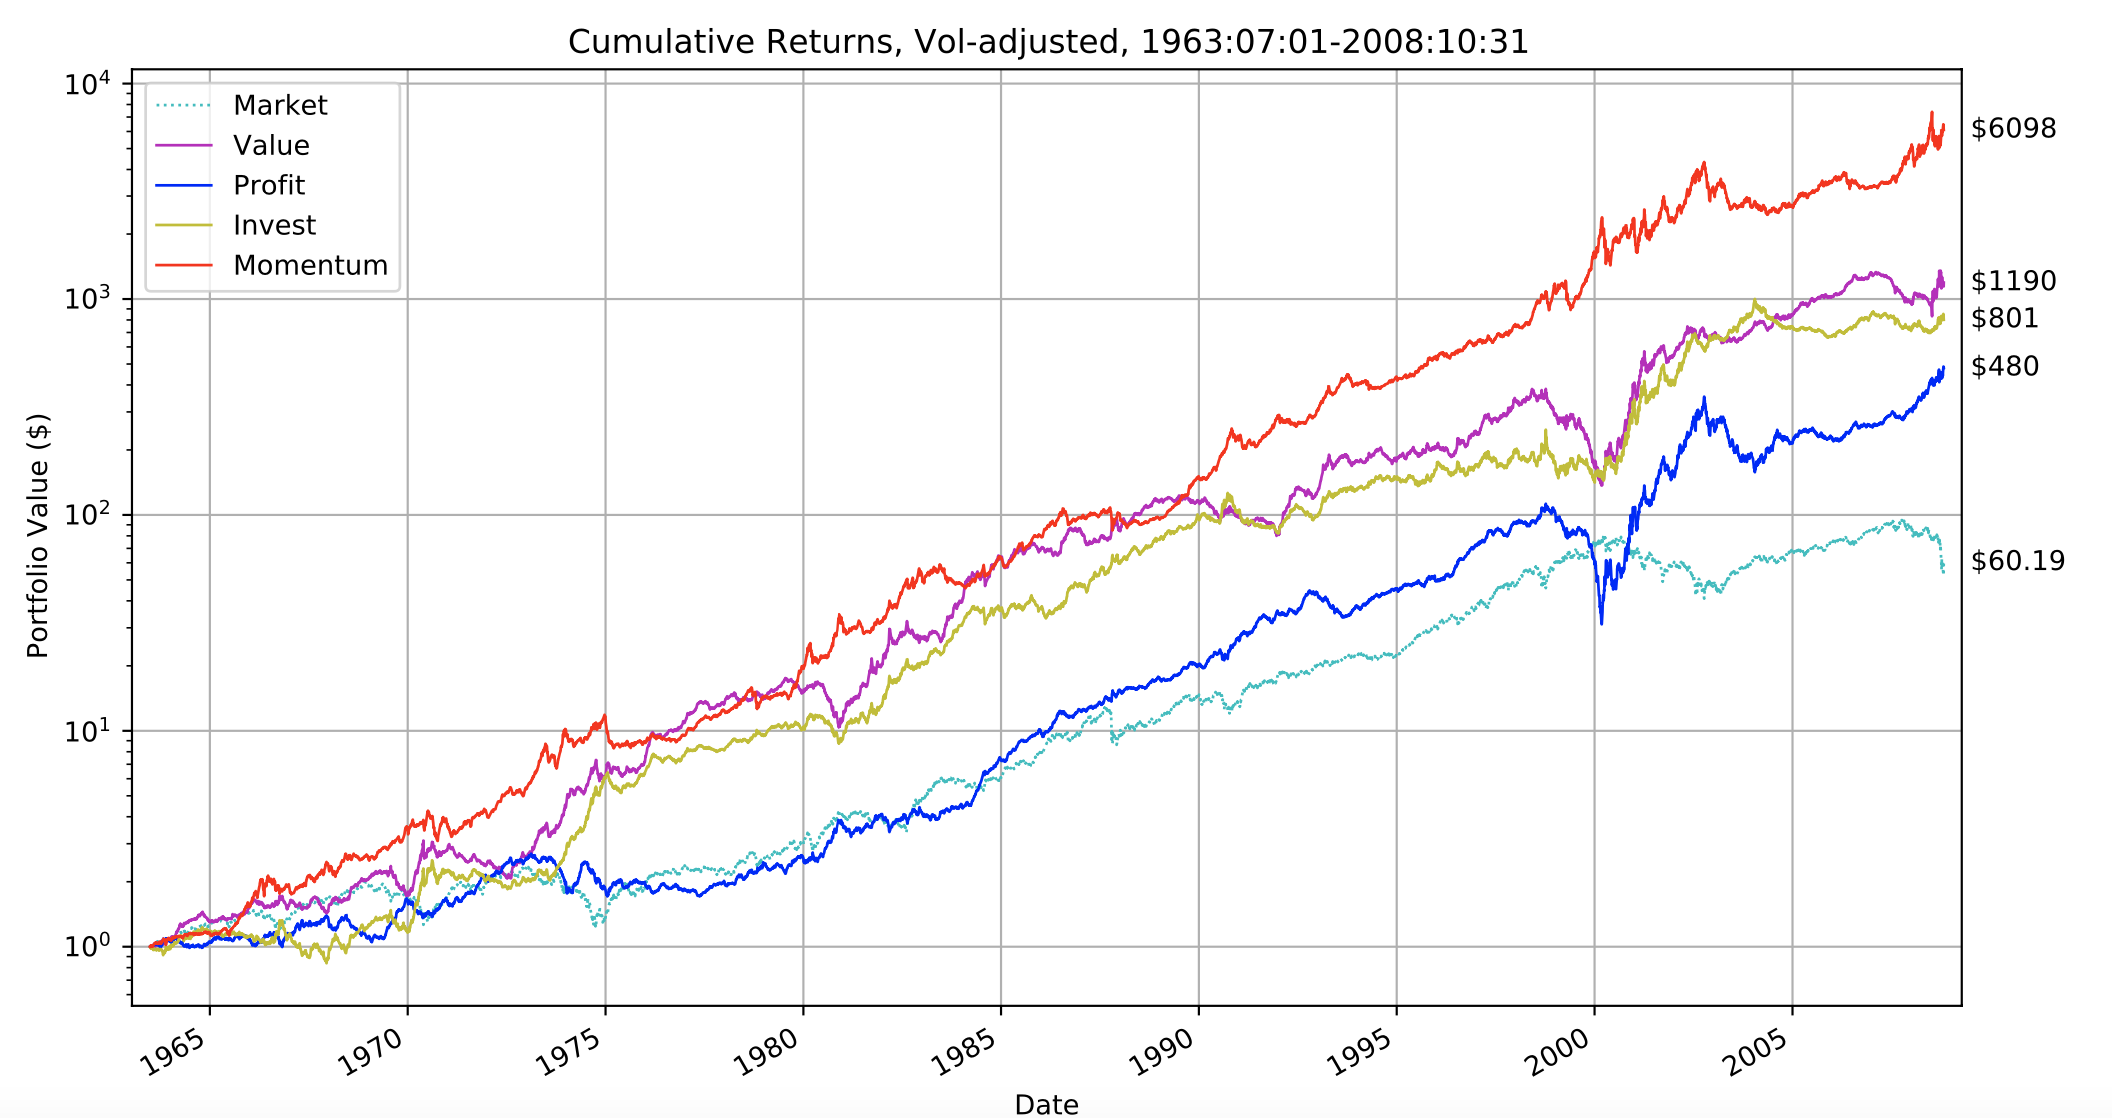

Time period here is 2008:11–2020:08

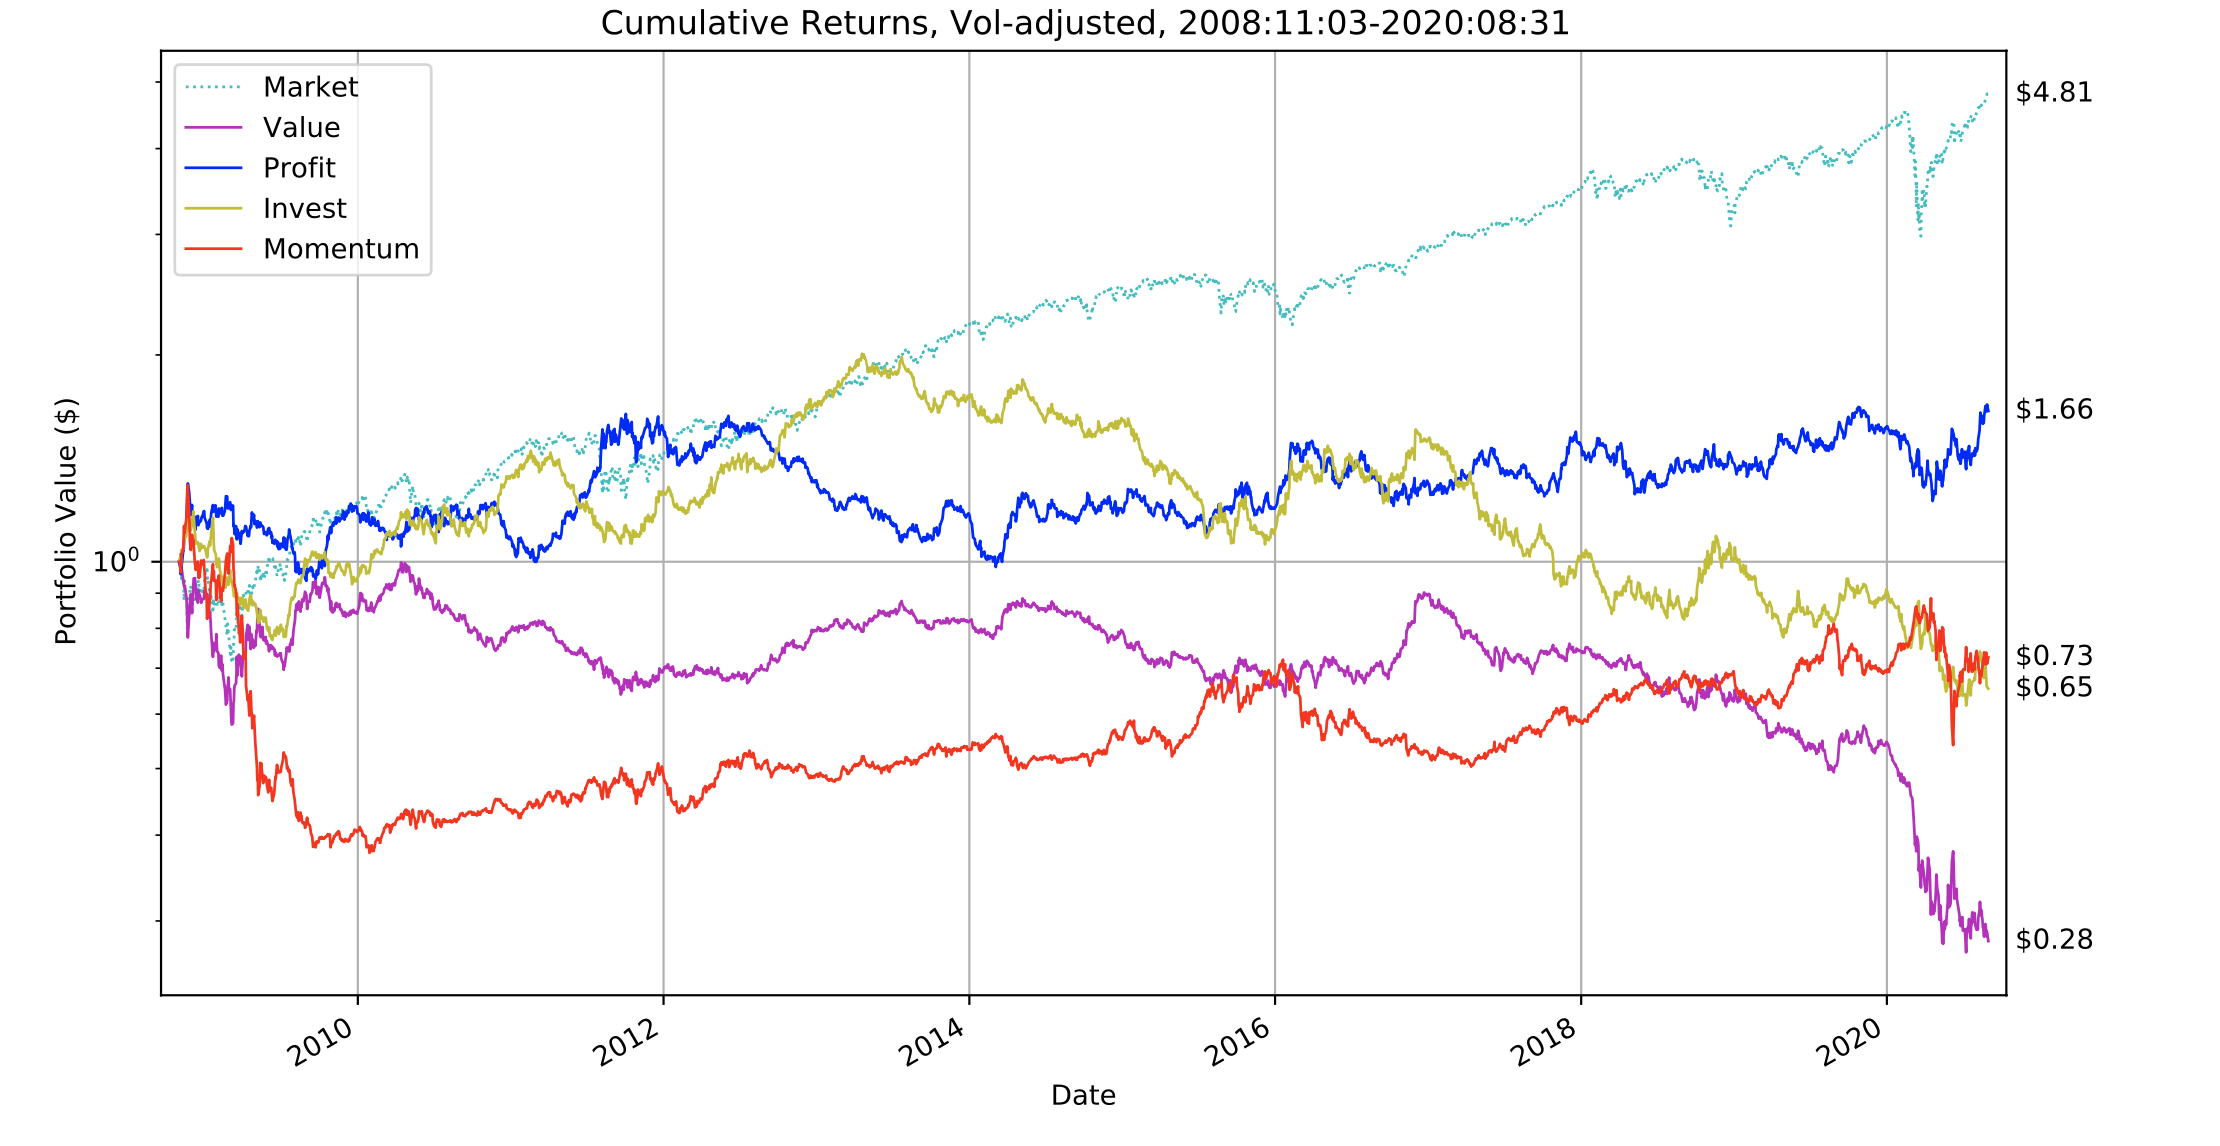

- In the 45 years leading up to the financial crisis, systematic value factors produced high returns and high SRs. <br>
<br>
- In the 12 years since, they have been a disaster.

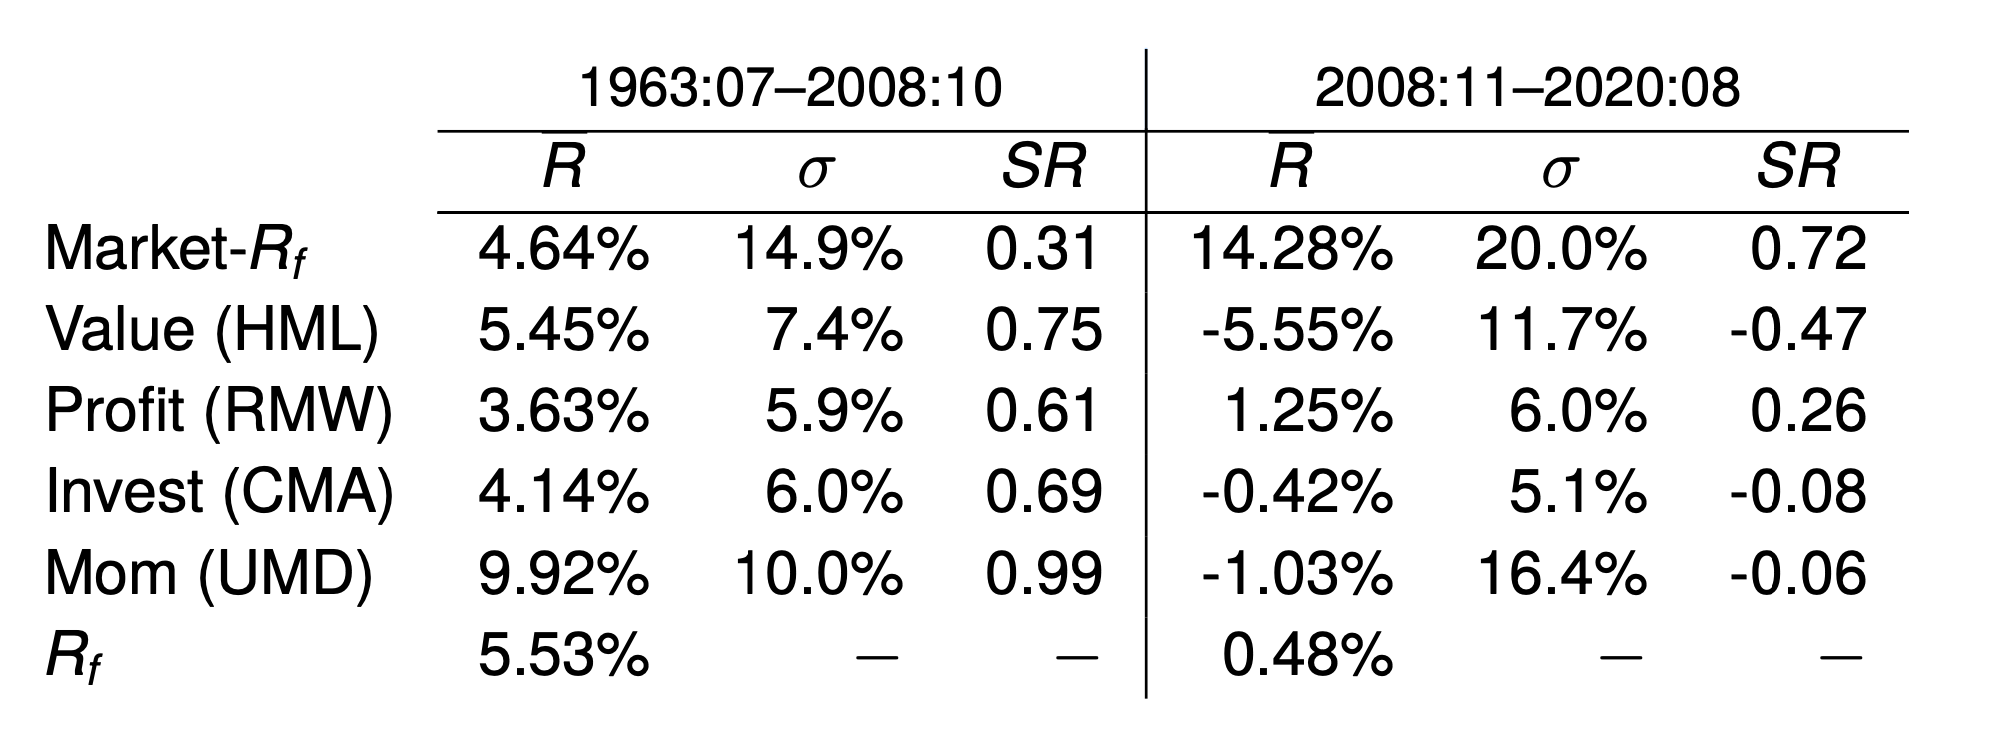

### Why?

* Many anomalies were really strong until they were “discovered”, and then have “disappeared”.  <br>
<br>
* This could be because:
   * They were never there in the first place
   * Once they were discovered they were, partially or fully, arbitraged away. 

### P-hacking or Arbitrage

#### What is p-hacking?

- Hypothesis testing via p-values:
  * Null hypothesis: $\beta = 0$
  * P-values are related to Type-I error: If the true value of $\beta$ is zero (the null hypothesis is true), we can obtain the observed data (OLS estimates) with the probability of the p-value.
  * However, we still have some chance to make mistakes (with the probability of the p-value). <br>
<br>
- Consider a data-mining experiment:
  * Researchers test 1,000 signals, regressing future stock returns into each individual signal and report the significant predictors if the p-value is smaller than 0.05. 
  * Suppose that all 1,000 signals are garbages, so they cannot predict stock returns. 
  * How many significant signals will the researchers identify in the simple linear regressions?

In [ ]:
np.random.seed(12345)
Tsim = 600
p = 1000
Rsim = np.random.normal(size=(Tsim,1))   # simulated stock returns
Xsim = np.random.normal(size=(Tsim,p))   # simulated signals
# Since stock returns and signals are drawn from independent normal distributions, 
# they are uncorrelated in nature.

In [ ]:
pvalues = np.zeros(p)

for i in range(p):
    model = sm.OLS(Rsim, sm.add_constant(Xsim[:,i:(1+i)]))  
    results = model.fit()
    pvalues[i] = results.pvalues[1]

In [ ]:
(pvalues < 0.05).sum()   
# At the statistical significance level of 5%, there are 50 signals that have non-zero coefficients;
# hence, these signals are identified as significant predictors for stock returns.

### Do the arbitrage activity and investor learning contribute to the declining performance of value?

**Reference:** McLean, R David, and Jeffrey Pontiff, 2016, Does academic research destroy stock return predictability?, Journal of Finance 71, 5–32.

* Key question: Does return-predictability typically persist outside the original sample? <br>
<br>
* McLean and Pontiff (2016) explore this question using 97 “predictors” documented in published academic studies, comparing returns over 3 periods:
   * Sample period from the original study
   * Post-sample, but pre-publication
      * Out-of-sample, but paper is not widely distributed
   * Post-publication
      * Paper distributed, more people know than before  <br>
<br>
* 97 predictors primarily in top 3 finance journals
   - Characteristics that can be constructed with COMPUSTAT, CRSP, and IBES data

#### Does Predictability = Statistical Artifact?

If so, predictability should disappear immediately out of sample

* Perhaps researchers choose methods and samples that give them their desired result

* Data Mining Bias

#### Does Predictability Reflect Risk and Costs?

Then predictability should be similar in-sample, out-of-sample, and post-publication

#### Does Predictability Reflect Mispricing?

Then publication should attract arbitrageurs, who correct the mispricing

- Costless arbitrage: The effect disappears entirely

- Costly arbitrage: Effect is reduced, not eliminated

#### Main Findings – Suggest Mispricing

* Out-of-sample, pre-publication decline is 26%
  - 1% monthly return declines to 0.74%  <br>
<br>
* Post-publication decay is 58%
  - 1% monthly return declines to 0.42% 
  - Implies a publication effect of 58%-26%=32%

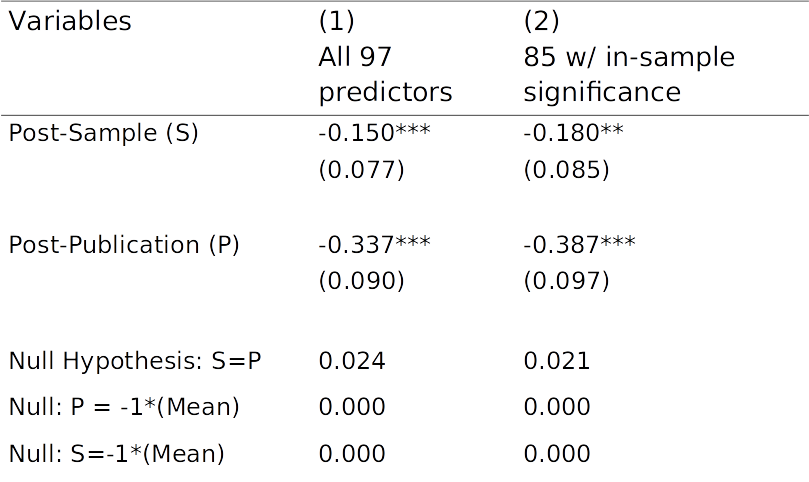

### Conclusion

- Although we cannot exclude the possibility of p-hacking, p-hacking cannot explain the declining yet still significant performance of many strategies after they were published. <br>
<br>
- Arbitrage activities play an important role in driving the post-publication performance. 

---

## 11.2 Accounting and Stock Return Data in WRDS

### Data Description

- US stock return data from CRSP (Center for Research in Security Prices)
   * Three stock exchanges: NYSE (New York Stock Exchange), NASDAQ (mostly tech firms), Amex (American Stock Exchange)  <br>
<br>
- Accounting information from COMPUSTAT
   * Define book common equity, BE, as the COMPUSTAT book value of stockholders' equity, plus balance-sheet deferred taxes and investment tax credit (if available), minus the book value of preferred stock.
   * Depending on availability, we use the redemption, liquidation, or par value (in that order) to estimate the value of preferred stock. <br>
<br>
- All these datasets are available in WRDS

In [ ]:
###################
# Connect to WRDS #
###################
conn=wrds.Connection()
#huangjthku

### 11.2.1 COMPUSTAT. Compute Book Equity using Accounting Data

In [ ]:
###################
# Compustat Block #
###################

# gvkey: Standard and Poor's Identifier; 
# datadate: data date
# at: total assets; 
# pstkl: Preferred Stock Liquidating Value; 
# txditc: Deferred Taxes and Investment Tax Credit; 
# pstkrv: Preferred Stock Redemption Value; 
# seq: Stockholders' Equity - Total; 
# pstk: Preferred/Preference Stock (book value) - Total; 

# Get the data from Compustat:
comp = conn.raw_sql("""
                    SELECT gvkey, datadate, at, pstkl, txditc,
                    pstkrv, seq, pstk
                    FROM comp.funda
                    WHERE indfmt='INDL' 
                    AND datafmt='STD'
                    AND popsrc='D'
                    AND consol='C'
                    AND datadate >= '01/01/2005'
                    AND datadate < '01/01/2010'
                    """)

In [ ]:
#comp = pd.read_parquet('data/lecture11/comp_ff3.parquet', engine='pyarrow')

In [ ]:
type(comp)

In [ ]:
comp.isnull().mean()

#### Estimating Book Equity (BE)

We follow the definition in Fama and French (1993):

* BE = book value of stockholders' equity (```comp['seq']```) + deferred taxes and investment tax credit (```comp['txditc']```) - book value of preferred stock.
   * Depending on availability, we use the following quantities (in that order) to estimate the book value of preferred stock:
      * redemption (```comp['pstkrv']```), 
      * liquidation (```comp['pstkl']```), 
      * par value (```comp['pstk']```). 
   * If deferred taxes or investment tax credit (```comp['txditc']```) is missing, we replace the missing entries with zeros. <br>
<br>
* Following the literature, we don't use negative-BE firms: Remove the firms with negative BE. <br>
    * Mostly, the firms with negative BE tend to have exotic/abnormal behaviors. 


#### Handle Missing Values:

In [ ]:
comp['datadate'] = pd.to_datetime(comp['datadate'])  # convert datadate to date fmt
comp['year'] = comp['datadate'].dt.year

In [ ]:
# create preferrerd stock
comp['ps'] = np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps'] = np.where(comp['ps'].isnull(), comp['pstk'], comp['ps'])
comp['ps'] = np.where(comp['ps'].isnull(), 0, comp['ps'])

#### How do you create ```comp['ps']``` using ```combine_first``` in pandas?

In [ ]:
comp['txditc'] = comp['txditc'].fillna(0)

#### Create book equity

In [ ]:
comp['be'] = comp['seq'] + comp['txditc'] - comp['ps']
comp['be'] = np.where(comp['be']>0, comp['be'], np.nan)

---

### 11.2.2 CRSP: US Stock Return Data

In [ ]:
##############
# CRSP Block #
##############

# a.permno: unique permanent security identification number assigned by CRSP to each security; 
# a.permco: CRSP Permanent Company Number; 
# b.shrcd: Share Code, common equity has shrcd 10 or 11; 
# b.exchcd: Exchange Code, 1 is NYSE, 2 is AMEX and 3 is NASDAQ; 
# a.ret: Holding Period Return; 
# a.retx: Holding Period Return without Dividends; 
# a.shrout: Number of Shares Outstanding; 
# a.prc: Price

# Get monthly stock data from "crsp.msf" (CRSP Monthly Stock): 
crsp_m = conn.raw_sql("""
                      SELECT a.permno, a.permco, a.date, b.shrcd, b.exchcd,
                      a.ret, a.retx, a.shrout, a.prc, b.siccd
                      FROM crsp.msf as a
                      LEFT JOIN crsp.msenames as b
                      ON a.permno=b.permno
                      AND b.namedt<=a.date
                      AND a.date<=b.nameendt
                      WHERE a.date between '01/01/2005' and '12/31/2010'
                      AND b.exchcd between 1 and 3
                      """) 

In [ ]:
# crsp_m = pd.read_parquet('data/lecture11/crsp_m_ff3.parquet', engine='pyarrow')

In [ ]:
crsp_m

In [ ]:
crsp_m.dtypes

In [ ]:
crsp_m.isnull().mean()

#### Change variable format to int

In some studies, you need to match the data based on, e.g., ```'permco'```, ```'permno'```, etc. 

Matching floating point numbers sometimes leads to unexpected errors (Lecture 1. Never compare two float numbers!)

In [ ]:
crsp_m[['permco','permno','shrcd','exchcd', 'siccd']] = crsp_m[['permco','permno','shrcd','exchcd', 'siccd']].astype(int)


#### Line up date to be end of month

- Some observations have ```date``` like "1969-11-28".
- Later on, you may need to merge ```crsp_m``` with other datasets; hence, we need to convert all the ```date``` objects to the end of the month. 

In [ ]:
crsp_m['date'] = pd.to_datetime(crsp_m['date'])
crsp_m['jdate'] = crsp_m['date'] + MonthEnd(0)

#### Drop financial firms: Standard Practice

Financial firms (e.g., banks) often have high leverages than other firms. 

Their risk exposures are normally different from others.

In asset pricing literature, we often create a seperate **financial intermediary factor** based on the returns on banks or other financial institutions. 

```(crsp_m['siccd'] >= 7000)|(crsp_m['siccd'] < 6000)```

In [ ]:
crsp_m = crsp_m[(crsp_m['siccd'] >= 7000)|(crsp_m['siccd'] < 6000)]

### The Delisting Bias in CRSP Data (Shumway, 1997, JF)

- Exchanges sometimes delist, or cease trading, stocks before investors are able to sell them.
    * Major stock exchanges (NYSE, AMEX,and Nasdaq) delist securities regularly for a variety of reasons. 
    * For example, exchanges drop securities when firms merge, when exchange offers make securities obsolete, when firms liquidate or move to another exchange, and when firms' performances fall below the exchange's listing criteria. <br>
<br>
- To correct for surprise delists, CRSP calculates delisting returns.
    * (The delisting return) is the return of the security after it is delisted. 
    * It is calculated by comparing a value after delisting against the price on the security's last trading date. <br>
<br>
- Omitted delisting returns introduce a bias into studies that use the CRSP data. Without delisting returns, it is not possible to accurately calculate the returns to a feasible portfolio. <br>
<br>
- Fortunately, CRSP creates another database that provides the data of delisted returns.

In [ ]:
dlret = conn.raw_sql("""
                     SELECT permno, dlret, dlstdt 
                     FROM crsp.msedelist
                     """)

In [ ]:
# dlret = pd.read_parquet('data/lecture11/dlret.parquet', engine='pyarrow')

In [ ]:
dlret.dtypes

In [ ]:
dlret.permno = dlret.permno.astype(int)
dlret['dlstdt'] = pd.to_datetime(dlret['dlstdt'])
dlret['jdate'] = dlret['dlstdt'] + MonthEnd(0)   # create an object to merge with crsp_m['jdate']
dlret = dlret.dropna()  # if delisting return is NaN, we do not have additional information

#### Now let's merge ```crsp_m``` with ```dlret``` based on ```['permno','jdate']```

In [ ]:
crsp = pd.merge(crsp_m, dlret, how='left', on=['permno','jdate'])

#### Calculate the adjusted returns based on the delisting dataset

When calculating the returns for delisted stocks, ```(1+dlret)*(1+ret)-1```  on the last trading date can serve as a quick and close approximation.

In [ ]:
### Remove the firm-month observations that have missing ret and dlret:
crsp = crsp[(crsp.dlret.isna()==False) | (crsp.ret.isna()==False)]

In [ ]:
crsp['dlret'] = crsp['dlret'].fillna(0)   
crsp['ret'] = crsp['ret'].fillna(0)
crsp['retadj'] = (1+crsp['ret'])*(1+crsp['dlret'])-1

In [ ]:
### Select the subsample containing delisting returns

#crsp.loc[crsp.dlstdt.isna()==False]

In [ ]:
crsp['me'] = crsp['prc'].abs()*crsp['shrout'] # calculate market equity
crsp = crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp = crsp.sort_values(by=['jdate','permco','me'])
crsp.head()

---

# END